В данном ноутбуке я создам базовый класс, на основе которого обучу сверточную графовую нейронную сеть.

Импортируем необходимые библиотеки

In [28]:
import os
import json
import numpy as np
import torch
import nni
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader, Classification
from nni.nas.hub.pytorch import DARTS as DartsSpace
from nni.nas.space import model_context
from tqdm import tqdm
from IPython.display import clear_output

from sklearn.preprocessing import OneHotEncoder
import re
import io
from graphviz import Digraph
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

import scipy.stats as sps

import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from IPython.display import clear_output

Основные операция DARTS search space. Добавил 'none' для начальных вершин.

In [2]:

DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')


Для графовой нейронной сети нам необходимо привести операции к числовому виду. Воспользуемся one-hot-encoder.

In [3]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


Загрузим архитектуры обученных моделей, их предсказания и точность.

In [4]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [5]:
models_dict = load_json_from_directory('second_dataset/')

Посмотрю как распределена точность моделей

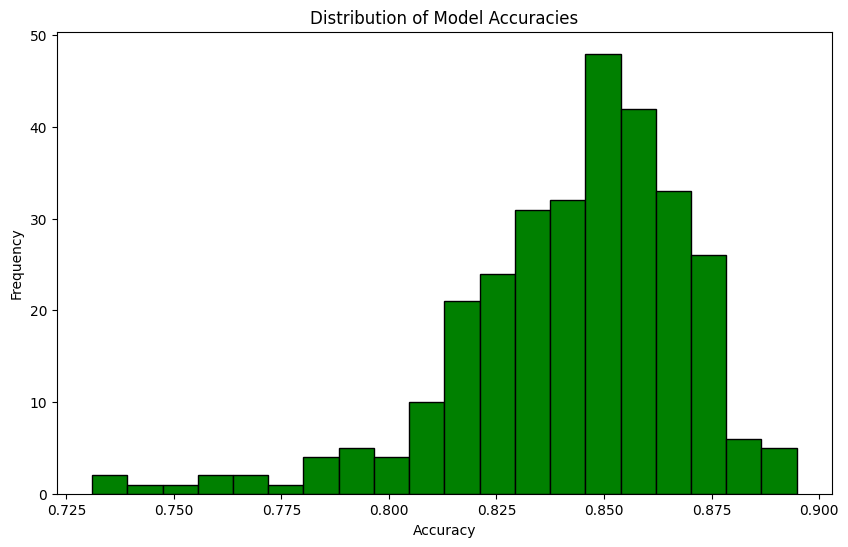

In [89]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=20, edgecolor='black', color="green")
plt.title('Distribution of Model Accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

In [7]:
def extract_cells(arch_dict):
    normal_cell, reduction_cell = [], []
    tmp_list = []

    for key, value in arch_dict["architecture"].items():
        if key.startswith("normal/") or key.startswith("reduce/"):
            tmp_list.extend([key, value])

        if len(tmp_list) == 4:
            tmp_list.pop(2)
            if key.startswith("normal/"):
                normal_cell.append(tmp_list)
            else:
                reduction_cell.append(tmp_list)
            tmp_list = []

    return normal_cell, reduction_cell

Создадам базовый класс узла графа

In [8]:
class Vertex:
    def __init__(self, op, in_channel, out_channel):
        self.op = op
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.op_one_hot = DARTS_OPS_ONE_HOT[DARTS_OPS.index(op)]

    def __str__(self):
        return f"Op: {self.op} | In: {self.in_channel} | Out: {self.out_channel}"
    def __repr__(self):
        return self.__str__()

Напишу сам класс графа. 

Замечу, что в классе будет хранится индекс соответствующий положению архитектуры в массиве словарей импортированном раннее.

In [9]:
class Graph(torch.utils.data.Dataset):
    def __init__(self, model_dict, index=0):
        self.model_dict = model_dict
        self.normal_cell, self.reduction_cell = extract_cells(model_dict)

        self._normal_graph = self.make_graph(self.normal_cell)
        self._reduction_graph = self.make_graph(self.reduction_cell)

        self.normal_num_vertices, self.reduction_num_vertices = self.__len__()

        self.graph = self.make_full_graph()
        self.index = index

    def __len__(self):
        max_normal_out = max(vertex.out_channel for vertex in self._normal_graph)
        max_reduction_out = max(vertex.out_channel for vertex in self._reduction_graph)
        return (max_normal_out, max_reduction_out)

    def graph_size(self, graph):
        return max((vertex.out_channel for vertex in graph), default=0)

    def make_full_graph(self):
        graph = [vertex for vertex in self._normal_graph]
        graph = self._unite_graphs(graph, self._normal_graph)

        return graph

    def _unite_graphs(self, graph1, graph2):
        graph1_size = self.graph_size(graph1)
        new_graph = [vertex for vertex in graph1]
        for vertex in graph2:
            new_vertex = Vertex(
                vertex.op,
                vertex.in_channel + graph1_size,
                vertex.out_channel + graph1_size,
            )
            new_graph.append(new_vertex)

        new_graph.sort(key=lambda vertex: (vertex.in_channel, vertex.out_channel))

        return new_graph

    def make_graph(self, cell):
        graph = []
        for value in cell:
            in_channel = int(value[2][0])
            out_channel = int(re.search(r"op_(\d+)_", value[0]).group(1))
            op = value[1]
            graph.append(Vertex(op, in_channel, out_channel))
        graph.append(Vertex("none", 0, 0))
        graph.append(Vertex("none", 1, 1))

        graph.sort(key=lambda vertex: (vertex.in_channel, vertex.out_channel))

        return graph

    def show_graph(self):
        graph = self.graph
        graph_name = "Graph"

        # Создаем объект Digraph
        dot = Digraph(comment=graph_name, format="png")
        dot.attr(rankdir="TB")  # Ориентация графа: сверху вниз (TB)

        # Добавляем узлы
        for idx, vertex in enumerate(graph):
            label = (
                f"{{Op: {vertex.op} | "
                f"In: {vertex.in_channel} | "
                f"Out: {vertex.out_channel}}}"
            )
            dot.node(str(idx), label=label, shape="record")

        # Добавляем связи между узлами
        connections = set()
        for src_idx, src_vertex in enumerate(graph):
            for dst_idx, dst_vertex in enumerate(graph):
                # Связь существует, если out_channel источника совпадает с in_channel приемника
                if src_vertex.out_channel == dst_vertex.in_channel:
                    if (src_idx, dst_idx) not in connections:
                        dot.edge(str(src_idx), str(dst_idx))
                        connections.add((src_idx, dst_idx))

        # Рендерим граф в Jupyter Notebook
        display(dot)

    def get_normal_graph(self):
        return self._normal_graph

    def get_reduction_graph(self):
        return self._reduction_graph

    def get_adjacency_matrix(self):
        adj_matrix_size = len(self.graph)
        adj_matrix = np.zeros(shape=(adj_matrix_size, adj_matrix_size))

        operations = [vertex.op for vertex in self.graph]
        operations_one_hot = [vertex.op_one_hot for vertex in self.graph]
        for i in range(adj_matrix_size):
            for j in range(adj_matrix_size):
                if j == i:
                    continue
                vertex_1 = self.graph[i]
                vertex_2 = self.graph[j]

                if vertex_1.out_channel == vertex_2.in_channel:
                    adj_matrix[i, j] = 1

        adj_matrix = np.array(adj_matrix)
        operations_one_hot = np.array(operations_one_hot)
        return adj_matrix, operations, operations_one_hot

In [10]:
graph = Graph(models_dict[0])

Посмотрю как выглядит граф.

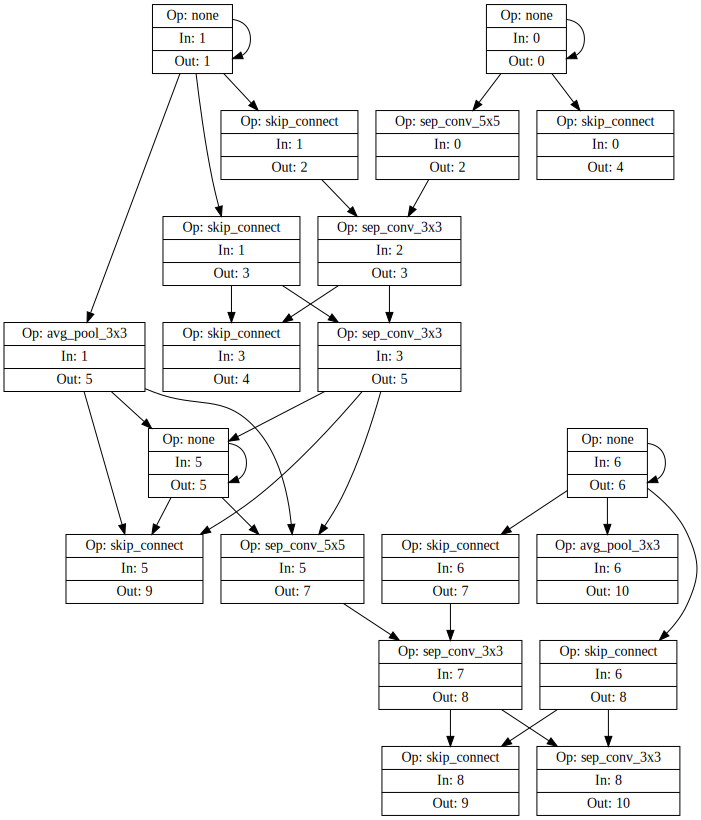

In [11]:
graph.show_graph()

In [12]:
graph._normal_graph

[Op: none | In: 0 | Out: 0,
 Op: sep_conv_5x5 | In: 0 | Out: 2,
 Op: skip_connect | In: 0 | Out: 4,
 Op: none | In: 1 | Out: 1,
 Op: skip_connect | In: 1 | Out: 2,
 Op: skip_connect | In: 1 | Out: 3,
 Op: avg_pool_3x3 | In: 1 | Out: 5,
 Op: sep_conv_3x3 | In: 2 | Out: 3,
 Op: skip_connect | In: 3 | Out: 4,
 Op: sep_conv_3x3 | In: 3 | Out: 5]

In [13]:
graph._reduction_graph


[Op: none | In: 0 | Out: 0,
 Op: sep_conv_3x3 | In: 0 | Out: 2,
 Op: max_pool_3x3 | In: 0 | Out: 3,
 Op: dil_conv_3x3 | In: 0 | Out: 5,
 Op: none | In: 1 | Out: 1,
 Op: dil_conv_5x5 | In: 1 | Out: 2,
 Op: avg_pool_3x3 | In: 1 | Out: 3,
 Op: skip_connect | In: 1 | Out: 4,
 Op: skip_connect | In: 3 | Out: 4,
 Op: dil_conv_3x3 | In: 3 | Out: 5]

Матрица смежности и описания узлов(сначала в виде строк, потом в виде one-hot векторов) представлены так

In [14]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

Рассчитаю разнообразие наивно -- просто буду говорить каков процент совпадений ответов у моделей 

In [15]:
def get_get_diversity(model_dict_1, model_dict_2):
    model_1_answers = np.array(model_dict_1["test_predictions"])
    model_2_answers = np.array(model_dict_2["test_predictions"])

    return np.mean(model_1_answers == model_2_answers)

Построю матрицу разнообразия

In [16]:
diversity_matrix = np.zeros((len(models_dict), len(models_dict))) + np.eye(
    len(models_dict)
)

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversity_matrix[i, j] = get_get_diversity(models_dict[i], models_dict[j])
        diversity_matrix[j, i] = diversity_matrix[i, j]

100%|██████████| 300/300 [01:02<00:00,  4.79it/s]


100%|██████████| 300/300 [00:00<00:00, 17380.19it/s]


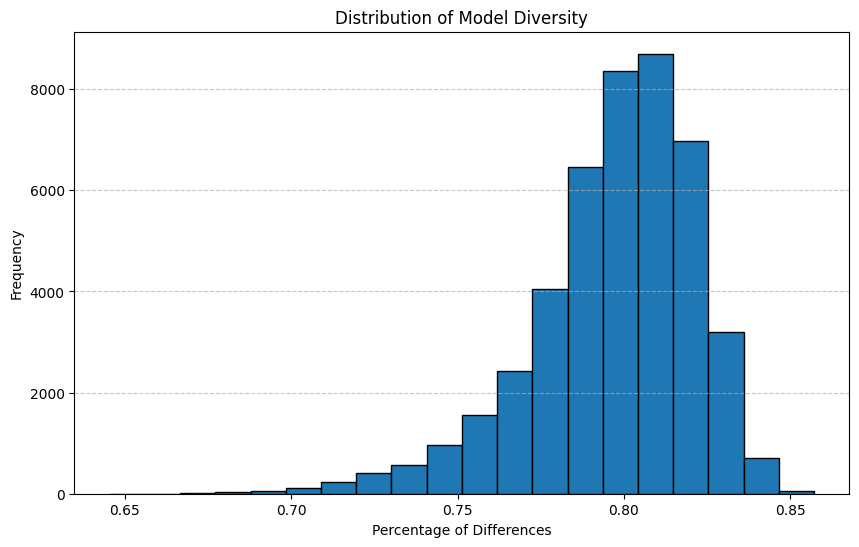

In [17]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=20, edgecolor="black")
plt.title("Distribution of Model Diversity")
plt.xlabel("Percentage of Differences")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Для triplet loss нам нужно будет подбирать positive и negative примеры, для этого удобно будет использовать дискретную матрицу разнообразия

In [18]:
def create_discrete_diversity_matrix(models_dict, diversity_matrix):
    discrete_diversity_matrix = np.zeros((len(models_dict), len(models_dict)))

    margins = np.quantile(diversity_matrix, 0.75, axis=1)
    discrete_diversity_matrix = (diversity_matrix > margins[:, None]).astype(int)

    return discrete_diversity_matrix

In [19]:
def get_positive_and_negative(diversity_matrix, index, dataset=None):
    positive = []
    negative = []
    
    positive = np.where(diversity_matrix[:, index] > 0)[0].tolist()
    negative = np.where(diversity_matrix[:, index] <= 0)[0].tolist()
    
    if dataset is not None:
        appropriate_indexes = [dataset[i][2] for i in range(len(dataset))]

        positive = [appropriate_indexes.index(idx) for idx in positive if idx in appropriate_indexes]
        negative = [appropriate_indexes.index(idx) for idx in negative if idx in appropriate_indexes]

    return np.random.choice(positive), np.random.choice(negative)

In [20]:
discrete_diversity_matrix = create_discrete_diversity_matrix(models_dict, diversity_matrix)

Код GCN

In [21]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, adj, x):
        support = self.linear(x)
        output = torch.spmm(adj, support)
        return output

class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=16):
        super(SimpleGCN, self).__init__()
        self.gc1 = GraphConvolution(input_dim, hidden_dim)
        self.gc2 = GraphConvolution(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = 0.5

    def forward(self, adj, x):
        x = F.relu(self.gc1(adj, x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(adj, x))
        x = F.dropout(x, self.dropout, training=self.training)

        x = torch.mean(x, dim=0)  # Усредняем по всем узлам графа
        x = self.fc(x)  # Теперь размерность соответствует [hidden_dim] → [output_dim]
        
        return x

Кастомный датасет, перевожу основные величины в тензоры

In [22]:
class CustomDataset(Dataset):
    def __init__(self, graphs):
        self.indexes = []
        self.adjs, self.features = [], []

        for graph in graphs:
            adj, _, features = graph.get_adjacency_matrix()
            adj, features = self.preprocess(adj, features)

            self.adjs.append(adj)
            self.features.append(features)
            self.indexes.append(graph.index)

    def preprocess(self, adj, features):
        """Преобразует матрицу смежности и признаки в тензоры."""
        adj = torch.tensor(adj, dtype=torch.float)
        features = torch.tensor(features, dtype=torch.float)
        return adj, features

    def __getitem__(self, index):
        return self.adjs[index], self.features[index], self.indexes[index]

    def __len__(self):
        return len(self.adjs)

Строим тренировочный и валидационный датасеты.

In [23]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(models_dict)]
graphs_dataset = CustomDataset(graphs)

# Определяем размеры тренировочного и тестового датасетов
train_size = int(0.8 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

# Разделяем датасет
train_dataset, valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(valid_dataset)}")

Train dataset size: 240
Test dataset size: 60


In [32]:
def triplet_loss(anchor, positive, negative, margin=0.1):
    return F.relu(margin + (anchor - positive).norm(2) - (anchor - negative).norm(2))

In [43]:
def train_model(model, train_dataset, valid_dataset, optimizer, criterion, num_epochs):
    """
    Функция для обучения модели.

    Аргументы:
        model (nn.Module): Модель для обучения.
        train_dataset (Dataset): Тренировочный датасет.
        valid_dataset (Dataset): Валидационный датасет.
        optimizer (torch.optim.Optimizer): Оптимизатор.
        criterion (nn.Module): Функция потерь.
        num_epochs (int): Количество эпох.

    Возвращает:
        tuple: Списки значений лосса за каждую эпоху для train и valid.
    """
    train_losses = []  # Список для хранения значений лосса на train
    valid_losses = []  # Список для хранения значений лосса на valid

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0  # Лосс для train за эпоху
        for i, data in enumerate(train_dataset):
            adj, features, index = data
            optimizer.zero_grad()

            # Прогон данных через модель
            outputs = model(adj, features)
            anchor = outputs
            positive_index, negative_index = get_positive_and_negative(discrete_diversity_matrix, index, train_dataset)

            positive = model(train_dataset[positive_index][0], train_dataset[positive_index][1])
            negative = model(train_dataset[negative_index][0], train_dataset[negative_index][1])

            # Расчет потерь
            loss = criterion(anchor, positive, negative)

            # Обратное распространение и шаг оптимизации
            loss.backward()
            optimizer.step()

            # Накопление лосса
            train_loss += loss.item()

        # Вычисление среднего лосса на train
        avg_train_loss = train_loss / len(train_dataset)
        train_losses.append(avg_train_loss)

        # Оценка модели на valid
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for i, data in enumerate(valid_dataset):
                adj, features, index = data

                outputs = model(adj, features)
                anchor = outputs
                positive_index, negative_index = get_positive_and_negative(discrete_diversity_matrix, index, valid_dataset)

                positive = model(valid_dataset[positive_index][0], valid_dataset[positive_index][1])
                negative = model(valid_dataset[negative_index][0], valid_dataset[negative_index][1])

                # Расчет потерь
                loss = criterion(anchor, positive, negative)
                valid_loss += loss.item()

        # Вычисление среднего лосса на valid
        avg_valid_loss = valid_loss / len(valid_dataset)
        valid_losses.append(avg_valid_loss)

        # Обновление графиков
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
        plt.plot(range(1, len(valid_losses) + 1), valid_losses, marker='o', label='Valid Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

    return train_losses, valid_losses

In [ ]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 64  # Размерность скрытого слоя
output_dim = 8 
num_epochs = 15

model = SimpleGCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=0.01)

Основной код обучения модели

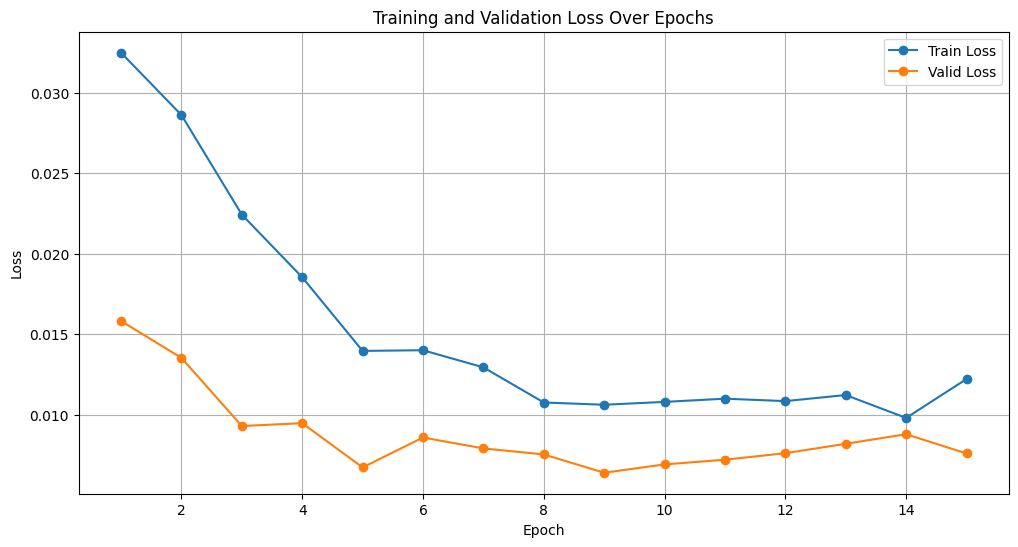

100%|██████████| 15/15 [04:19<00:00, 17.27s/it]

Epoch 15, Train Loss: 0.0122, Valid Loss: 0.0076


In [83]:
train_model(model, train_dataset, valid_dataset, optimizer, criterion, num_epochs);

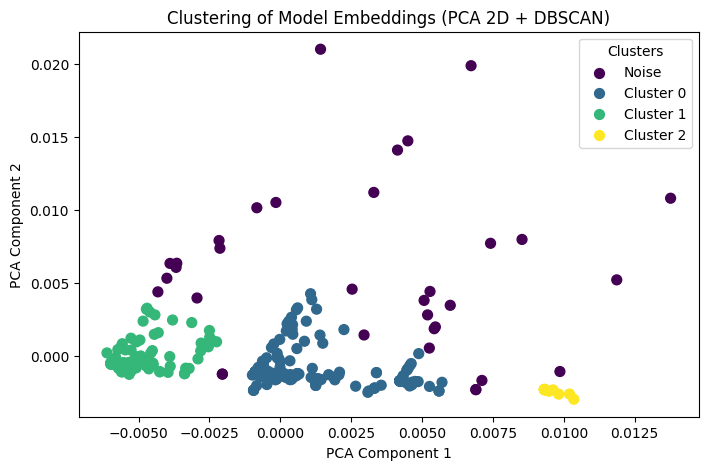

In [99]:
def extract_embeddings(model, dataset, device):
    """
    Извлекает эмбеддинги (выходы модели) для всех примеров в датасете.
    
    Аргументы:
      model (nn.Module): обученная модель.
      dataset (Dataset): датасет, из которого извлекаются эмбеддинги.
      device (torch.device): устройство, на котором работает модель.
    
    Возвращает:
      embeddings (numpy.ndarray): матрица эмбеддингов (num_samples x embedding_dim).
      indices (list): список индексов (или меток) для примеров.
    """
    model.eval()
    embeddings = []
    indices = []
    with torch.no_grad():
        for i, data in enumerate(dataset):
            adj, features, index = data
            adj = adj.to(device)
            features = features.to(device)
            output = model(adj, features)
            embeddings.append(output.cpu().numpy())
            indices.append(index)
    embeddings = np.vstack(embeddings)
    return embeddings, indices

embeddings, indices = extract_embeddings(model, graphs_dataset, "cpu")

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Применяем DBSCAN для кластеризации
dbscan = DBSCAN(eps=0.001, min_samples=5)  # eps и min_samples можно настроить под ваши данные
clusters = dbscan.fit_predict(embeddings_2d)

# Строим 2D-график с кластерами
plt.figure(figsize=(8, 5))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', s=50)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering of Model Embeddings (PCA 2D + DBSCAN)")

# Создаем легенду для кластеров
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
  if cluster == -1:
    label = "Noise"
  else:
    label = f"Cluster {cluster}"
  plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label, s=50)

plt.legend(title="Clusters", loc="upper right")
plt.show()

In [92]:
indexes = np.where(clusters == 0)
print(indexes)

get_get_diversity(models_dict[indexes[0][0]], models_dict[indexes[0][6]])

(array([  0,   1,   4,   6,   8,  14,  15,  16,  18,  19,  21,  22,  23,
        24,  25,  26,  27,  30,  32,  33,  35,  36,  38,  39,  43,  47,
        50,  52,  54,  55,  58,  60,  61,  63,  64,  65,  69,  70,  71,
        74,  75,  78,  79,  80,  81,  82,  85,  87,  89,  91,  93,  94,
        95,  97,  99, 101, 102, 103, 104, 106, 107, 108, 110, 114, 115,
       116, 119, 120, 121, 122, 123, 124, 128, 130, 133, 134, 137, 138,
       140, 148, 149, 150, 151, 153, 154, 155, 160, 161, 163, 167, 170,
       171, 173, 176, 177, 182, 184, 185, 188, 191, 192, 193, 194, 196,
       197, 200, 202, 206, 207, 208, 212, 214, 220, 221, 223, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 247, 250, 252,
       255, 256, 258, 259, 260, 261, 263, 264, 265, 268, 269, 270, 271,
       273, 274, 276, 278, 279, 280, 283, 284, 285, 286, 290, 291, 292,
       293, 296, 297, 299]),)


0.7683